In [5]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
from typing import List, Dict, Any, Tuple
import pickle
import torch
# from utilsHannes import mean_pointwise_l2_distance

def mean_pointwise_l2_distance(lattice: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
    """
    Computes the index of the closest trajectory in the lattice as measured by l1 distance.
    :param lattice: Lattice of pre-generated trajectories. Shape [num_modes, n_timesteps, state_dim]
    :param ground_truth: Ground truth trajectory of agent. Shape [1, n_timesteps, state_dim].
    :return: Index of closest mode in the lattice.
    """
    stacked_ground_truth = ground_truth.repeat(lattice.shape[0], 1, 1)
    return torch.pow(lattice - stacked_ground_truth, 2).sum(dim=2).sqrt().mean(dim=1).argmin()


# Load lattice
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories8 = pickle.load(f)
lattice8 = np.array(trajectories8)
              
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_4.pkl', 'rb') as f:
    trajectories4 = pickle.load(f)
lattice4 = np.array(trajectories4)
    
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
    trajectories2 = pickle.load(f)
lattice2 = np.array(trajectories2)

dataset_factor_list = [1,1,1,1,1,1,1,1,1,1]
lattice_list = [lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4,lattice4]
modes_list = [415,415,415,415,415,415,415,415,415,415]

In [6]:
### Non-IID - Balanced
folder_path = "saveResults/from_other_servers/ClientNumber_non-IID"
num_clients_list = ['1','2','4','8']
file_suffix_list = [f"balanced_C={num_clients}_Cf=1.0_Ef=1.0_B=8_E=1_R=500_Opt=saveFedAvg_Lr=0.0001" for num_clients in num_clients_list]
legend_list = [f'{num_clients}' for num_clients in num_clients_list]
num_epochs = 500

In [7]:
# Settings
file_number = 0
train_boolean = 'no' # yes
num_files = len(file_suffix_list)

indices_loaded_list = [(np.load(f'{folder_path}/val_indices_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]
probabilities_list = [(np.load(f'{folder_path}/val_probabilities_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]
ground_truth_loaded_list = [(np.load(f'{folder_path}/val_ground_truth_{file_path}.npy'))[:num_epochs*512*dataset_factor] for file_path, dataset_factor in zip(file_suffix_list, dataset_factor_list)]

#################################################################################################################################


# Print the data
print(f"len(indices_loaded_list) = {len(indices_loaded_list)}")
print(f"len(probabilities_list) = {len(probabilities_list)}")
print(f"len(ground_truth_loaded_list) = {len(ground_truth_loaded_list)}")
print(f"indices_loaded_list[{file_number}].shape = {indices_loaded_list[file_number].shape}")
print(f"probabilities_list[{file_number}].shape = {probabilities_list[file_number].shape}")
print(f"ground_truth_loaded_list[{file_number}].shape = {ground_truth_loaded_list[file_number].shape}")

len(indices_loaded_list) = 4
len(probabilities_list) = 4
len(ground_truth_loaded_list) = 4
indices_loaded_list[0].shape = (256000, 15)
probabilities_list[0].shape = (256000, 15)
ground_truth_loaded_list[0].shape = (256000, 12, 2)


predicted = 273
closest_lattice_index = 13
correct = False


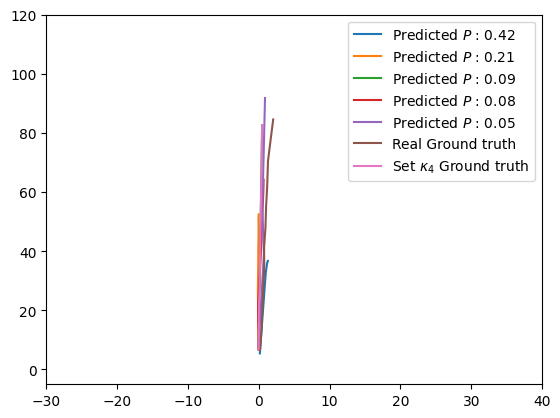

In [74]:
## Plot prediction vs ground truth
epoch = 450
index = 46 # 450,83 + 450,32 struggling + 450,33 struggling lots + 450,39 straight + 450,41 + 450,46 straight + 450,63 + 250,4 right + 250,16 left
if train_boolean == 'yes':
    test_index = epoch*2048*dataset_factor_list[file_number] + index
else: 
    test_index = epoch*512*dataset_factor_list[file_number] + index

nrOfTopTrajectories = 5
predicted_indices = indices_loaded_list[file_number][test_index]
probabilities = probabilities_list[file_number][test_index]
ground_truth_trajectory = ground_truth_loaded_list[file_number][test_index]
closest_lattice_index = mean_pointwise_l2_distance(torch.Tensor(lattice_list[file_number]), torch.Tensor(ground_truth_trajectory))
topProbabilitiesIndices = predicted_indices[:nrOfTopTrajectories]
topProbabilities = probabilities[:nrOfTopTrajectories]

# Lattice ground truth
predicted = topProbabilitiesIndices[0]
print(f"predicted = {predicted}")
print(f"closest_lattice_index = {closest_lattice_index}")
correct = (predicted == closest_lattice_index)
print(f"correct = {correct}")

[plt.plot(lattice_list[file_number][mode,:,0],lattice_list[file_number][mode,:,1], label=f"Predicted $P$ : {topProbabilities[i]:.2f}") for i, mode in enumerate(topProbabilitiesIndices)]
plt.plot(ground_truth_trajectory[:,0], ground_truth_trajectory[:,1], label="Real Ground truth")
plt.plot(lattice_list[file_number][closest_lattice_index,:,0],lattice_list[file_number][closest_lattice_index,:,1], label="Set $\kappa_4$ Ground truth")
plt.ylim([-5,120]); plt.xlim([-30,40]); plt.legend(); plt.show()